## NLP Project  - Surendiran Rangaraj
**Date : 12/1/2021**


Illinois is famous for being one of the very few states in the country with negative population growth.  The objective of your final project is to:

    1. Identify the key reasons for the declining population (what people like / dislike about Chicago / suburbs) by extracting meaningful insights from unstructured text
    2. Provide actionable recommendations on what can be done to reverse this trend (how to make Chicago / suburbs more attractive)
    
You have access to a collection of ~200K news articles (about 500 MB).  The news articles are related to either Chicago and / or Illinois and you can access them in the following ways:

    . Download a data by following this think from your browser: https://storage.googleapis.com/msca-bdp-data-open/news/news_final_project.jsonLinks to an external site.
    . Use Spark on GCP news_final_project = spark.read.parquet('gs://msca-bdp-data-open/news_final_project')
    . Use Pandas from anywhere (your laptop, Colab or any cloud) df_news_final_project = pd.read_json('https://storage.googleapis.com/msca-bdp-data-open/news/news_final_project.json', orient='records', lines=True) 
 

To complete your assignment, I suggest considering the following steps:

    . Clean-up the noise (eliminate articles irrelevant to the analysis)
    . Detect major topics
    . Identify top reasons for population decline (negative sentiment)
        . Suggest corrective actions
        . Plot a timeline to illustrate how the sentiment is changing over time
    . Demonstrate how the city / state can attract new businesses (positive sentiment)
    . Leverage appropriate NLP techniques to identify organizations and people and apply targeted sentiment
        . Why businesses should stay in IL or move into IL?
            . Create appropriate visualization to summarize your recommendations (i.e. word cloud chart or bubble chart)
        . Why residents should stay in IL or move into IL?
            . Create appropriate visualization to summarize your recommendations (i.e. word cloud chart or bubble chart)

**Additional guidance:**

    . Default sentiment will likely be wrong from any software package and will require significant tweaking
        . Either keyword / dictionary approach or
        . Labeling and classification
        
    . You are encouraged to explore a combination several techniques to identify key topics:
        . Topic modeling (i.e. LDA using gensim or ktrain)
        . Classification (hand-label several topics on a sample and then train classifier)
        . Clustering (cluster topics around pre-selected keywords or word vectors)
        . Zero-shot (NLI) modeling
        . Please ensure your PowerPoint presentation (in PPTX or PDF format) is submitted to the course module as-is (not zipped). Otherwise I am unable to use Canvas SpeedGrader.
        . The presentation should look professional – not a collection of screenshots from your analytical software
        . Roughly 8-12 pages is reasonable for this kind of project but there are no strict restrictions.
        . On your slides you will want to provide:
            . Executive Summary
            . Methodology and source data overview
            . Actionable recommendations
            . Apply text summarization algorithms where possible to synthesize your insights
        . Please submit your actual program codes (Jupyter notebooks) along with your PowerPoint
        . The slides should be self-sufficient and after reading them, there should not be any need to read the notebook (we are still asking you to provide the notebooks as a proof or work though).
        . The slides should clearly answer all the questions and the answers should be supported with the plots/tables/numbers produced in the notebook based on the actual data.
        . The slides should contain the RIGHT amount of supporting material for each question, putting too much supporting material is as bad as putting too little: too much - you would not be able to keep the audience attention and your presentation would be a mess, too little - your statements would not look convincing.
        . Everything should be clear, logical, well organized, as simple as possible.  Use proper English and run spell check.
        . All the plots should be of production quality and easily readable. Foggy plots, untitled plots, unreadable labels, overlapping labels are unacceptable.
        . If you formatting somehow gets corrupted when you put your slides into Canvas (sometimes it happens), it is your responsibility to fix formatting. For example, try saving it in some other format like PDF, HTML.
        . Any statements you make should be supported by data. Only recommendations or goals of the project sections can contain elements not directly supported by the data
        . Please submit your actual program codes (i.e. Python Notebook) along with your PowerPoint – as a separate attachment
            . Your presentation should be targeted toward business audience and must not contain any code snippets
    .You are welcome to use any software packages of your choice to complete the assignment

### Import Libraries

In [1]:
!pip install ktrain

In [2]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [3]:
import sys
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import pickle
import re
import string
import matplotlib
from matplotlib import pyplot as plt
import nltk as nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

import time
import math
from pprint import pprint
from textblob import TextBlob

import spacy
import multiprocessing
import string
from spacy import displacy
from collections import Counter
print(spacy.__version__)
print('Python Version: ' + sys.version)
print('TensorFlow Version: ' + tf.__version__)

2.2.4
Python Version: 3.7.12 (default, Sep 10 2021, 00:21:48) 
[GCC 7.5.0]
TensorFlow Version: 2.7.0


In [4]:
pd.set_option('display.max_rows', 500) # Set Max Number of Rows
pd.set_option('display.max_columns', 50) # Set Max Number of Columns
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 50) # Set Max Width of Cell
pd.set_option('display.max_info_columns', 200) # Set Max Number of Columns Shown in info()
pd.set_option('display.precision', 6)#Set Display Precision of float values (0.123456)
#pd.options.display.float_format = '{:.2f}%'.format # Set Decimal Format (0.12%)

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
# the base Google Drive directory
root_dir = "/content/drive/My Drive/"
# choose where you want your project files to be saved
project_folder = "Colab Notebooks/NLP/yelp/"
data_folder = "Colab Notebooks/NLP/yelp/"
dataPath = root_dir+data_folder
print("dataPath: " , dataPath)

dataPath:  /content/drive/My Drive/Colab Notebooks/NLP/yelp/


In [7]:
from google.colab import files
#uploaded = files.upload()

### Read Topic added with Sentiments Data

In [8]:
news_topics_sentiment_df = pd.read_json(dataPath+"news_with_Topics_Sentiments_proba.json",orient='records',lines=True)

In [9]:
news_topics_sentiment_df.head(5)

,index,Unnamed: 0,date,language,title,text,text_clean,title_clean,rake_phrases,Top_Topic_Assigned,Perc_Contribution,Topic_Keywords,neg_prob,pos_prob,sentiment
0,0,0,2021-07-23,english,chicago theater seating chart with seat numbers,Chicago Theatre Seating Chart With Seat Number...,Chicago Theatre Seating Chart With Seat Number...,chicago theater seating chart with seat numbers,mix wtmx chicago theatre seat numbers online c...,60,0.5188,"restaurant, food, order, pizza, menu, eat, ser...",0.008034,0.991966,Postive
1,1,1,2021-07-24,english,harris theater chicago seating chart,Harris Theater Seatmap Chicago Opera Theater C...,Harris Theater Seatmap Chicago Opera Theater C...,harris theater chicago seating chart,harris theater seatmap chicago opera theater c...,46,0.2848,"chart, seating_chart, seat, guide, flight_deal...",0.055082,0.944918,Postive
2,2,2,2020-12-15,english,There's a Big Tree Growing Through a Car in Il...,"Published: December 14, 2020 nanjan\nWe're not...","Published: December 14, 2020 nanjanWere not ex...",Theres a Big Tree Growing Through a Car in Ill...,illinois abandoned images troy shepard illinoi...,87,0.7097,"go, get, know, want, say, s, think, see, peopl...",0.039648,0.960352,Postive
3,3,3,2020-03-05,english,Former Fox White House reporter Wendell Goler ...,"National News FILE - This May 4, 2010 file pho...","National News FILE This May 4, 2010 file phot...",Former Fox White House reporter Wendell Goler ...,2010 file photo shows fox news channels wendel...,6,0.4453,"say, vote, support, state, people, president, ...",0.008716,0.991284,Postive
4,4,4,2020-12-30,english,I am looking forward to many things in 2021. I...,I am looking forward to many things in 2021. I...,I am looking forward to many things in 2021. I...,I am looking forward to many things in 2021. I...,"illinois basketball returning, weeks stories, ...",87,0.6493,"go, get, know, want, say, s, think, see, peopl...",0.000244,0.999756,Postive


In [10]:
news_topics_sentiment_df["sentiment"].replace({"Postive": "Positive"}, inplace=True)

**Review Sample Articles from each Topic**

In [11]:
pd.set_option('display.max_colwidth', 20000) 
news_topics_sentiment_df[news_topics_sentiment_df.Top_Topic_Assigned.isin(['57'])].text.sample(n=10)

81628                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

In [12]:
##Exodus- Review sample article of people leaving
news_topics_sentiment_df.text.iloc[143593]

'Blame Illinois exodus on jobs, housing, tax policy\nBy Orphe Divounguy:\nCensus data shows who is fleeing Illinoisans and why. Here’s why you should care.\nIllinois lost more than 850,000 residents to other states during the past decade, causing the state’s population to shrink for six consecutive years and suffer the largest raw decline of any state in the 2010s. The Archives Dispatches University Videos Quotes\n“During the course of administration, and in order to disturb it, the artillery of the press has been levelled against us, charged with whatsoever its licentiousness could devise or dare. These abuses of an institution so important to freedom and science are deeply to be regretted, inasmuch as they tend to lessen its usefulness and to sap its safety.” —Thomas Jefferson (1805)'

### Sentiment over time of all news articles over time

Filter Negative sentiment probabilities, sort the articles by date , average the sentiment for each data

In [13]:
sentimentAnalyzerDF = news_topics_sentiment_df[['date','neg_prob']]
sentimentAnalyzerDF.sort_values('date',inplace=True)
sentimentAnalyzerDF.reset_index(inplace=True,drop=True)
sentimentAnalyzerDF1 = sentimentAnalyzerDF.groupby(['date'],as_index=False)[['neg_prob']].mean()
sentimentAnalyzerDF1.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,date,neg_prob
0,2018-01-22,0.387309
1,2018-01-23,0.380084
2,2018-01-24,0.401192
3,2018-01-25,0.380337
4,2018-01-26,0.441169


In [14]:
len(sentimentAnalyzerDF1)

802

Sentiment Negative probabilities over date

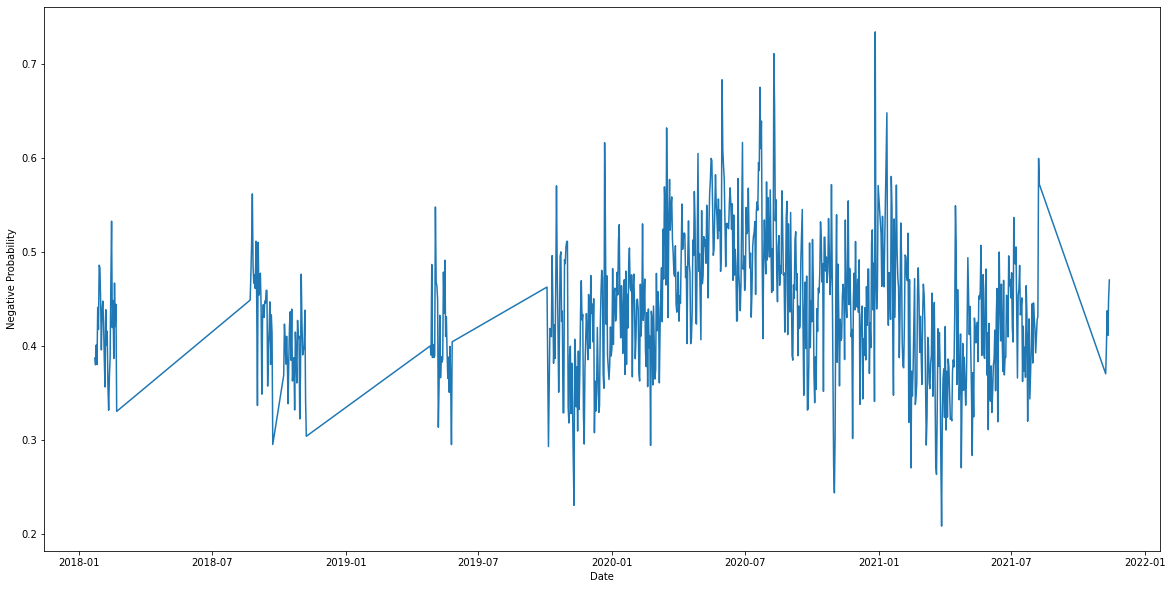

In [15]:
import seaborn as sns
plt.figure().set_size_inches(20, 10)

sns.lineplot(data = sentimentAnalyzerDF1,x="date" , y = 'neg_prob')
plt.xlabel('Date')
plt.ylabel('Negative Probability')
plt.show()

Sentiment Negative probabilities over index

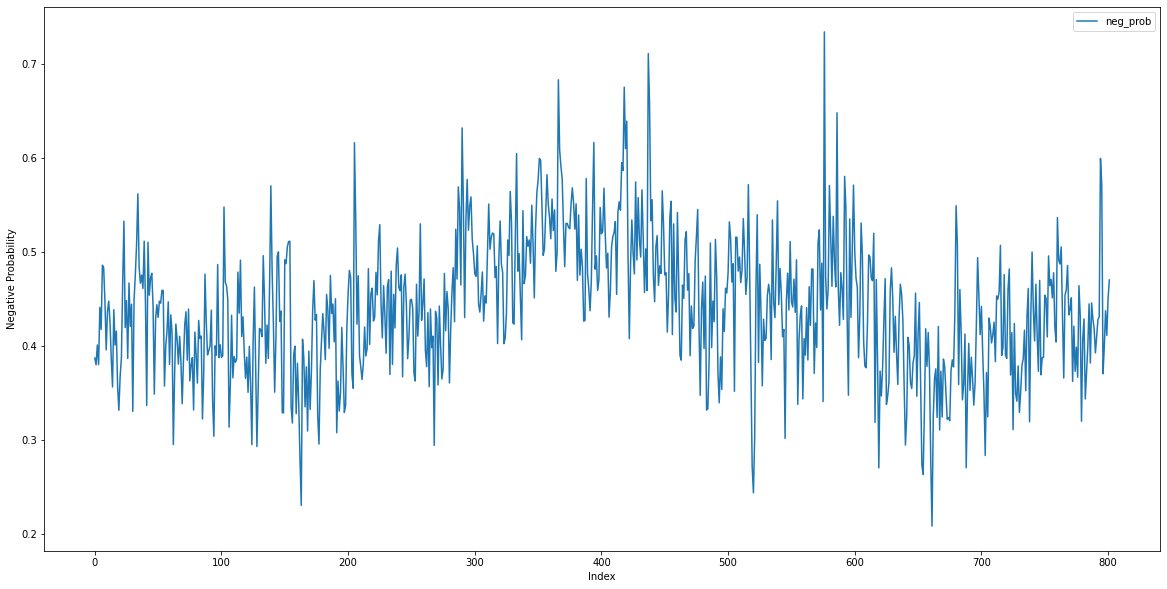

In [16]:
plt.figure().set_size_inches(20,10)

sns.lineplot(data = sentimentAnalyzerDF1)

plt.xlabel('Index')
plt.ylabel('Negative Probability')
plt.show()

### Filter the Relevant Topics

#### Filter Keywords related to population decline

In [30]:
#Search_text = ('tax|pension|employment|policy|immigration|economy|housing')
#search_text = ('population|decline|population decline|exodus|tax hike| tax ')
chicago_relevant_df = news_topics_sentiment_df[news_topics_sentiment_df['text_clean'].str.contains('chicago', case=False, na=False)]
len(chicago_relevant_df)

121878

In [17]:
#Search_text = ('tax|pension|employment|policy|immigration|economy|housing')
search_text = ('population|decline|population decline|exodus|tax hike| tax ')
illinois_relevant_df = news_topics_sentiment_df[news_topics_sentiment_df['text_clean'].str.contains(search_text, case=False, na=False)]

In [18]:
len(illinois_relevant_df)

14706

In [19]:
illinois_relevant_df.text.sample(n=10)

148307    Contact Us Chicago Leads the Fight for Food Justice by Building Innovative Local Food Ecosystems Communities are using urban farming, integrated service chains and other new programs to feed and empower the 630,000 hungry people living in Illinois’ Cook County. Editor’s note: This story was produced in partnership with StreetWise , a street media paper in Chicago, and is part of “The Right to a Home,” a Community Based News Room (CBNR) series that examines homelessness issues across the United States. CBNR is a project of Law@the Margins , and the eight-part series is supported by a Solutions Journalism Network grant. Lee Holmes was a source for this story and also contributed reporting and writing.\nW hen StreetWise vendor Lee Holmes moved out of a friend’s home and onto the street, he found himself unsure of where to find food going forward, so he quickly downloaded a list of regular meal programs from the Greater Chicago Food Depository ’s website.\nSearching for food prog

#### Load the 100 topics ,join and filter the relevant topics

Each of the 100 Topics that were created as part of LDA model was manually reviewed and updated the topics that are relevant to the project manaully. 

In [20]:
pd.set_option('display.max_colwidth', 200) 
load_relevant_topics100_df = pd.read_csv(dataPath+"Topic100_with_Keywords_relevance.csv")
load_relevant_topics100_df = load_relevant_topics100_df[load_relevant_topics100_df['Relevant'] == 'Yes']
print(len(load_relevant_topics100_df))
load_relevant_topics100_df.head()

25


,Topic,Topic_Sno,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,Relevant,Topic_Name,Sentiment
1,Topic 2,1,charge,arrest,prison,accord,sentence,release,convict,murder,jail,year,say,crime,case,death,accuse,Yes,Crime,Negative
4,Topic 5,4,shoot,take,block,say,man,accord,police_said,scene,hospital,car,vehicle,victim,police,strike,kill,Yes,Crime,Negative
5,Topic 6,5,office,selling_home,ranked_th,highest_price,home_quickly,best_state,algonquin,education,area_well_sell,regional_office,county_community_unit_school,illinois_new,recommended_video,educating_student,content_dec,Yes,NaN,Neutral
8,Topic 9,8,airport,flight,travel,fly,passenger,plane,airline,ohare,train,bus,source,aircraft,traveler,pilot,registration,Yes,NaN,Neutral
10,Topic 11,10,mccormick_place,sneaker,date,chicago_accident_lawyer,spit,great_place,nike,chicago_auto_show,best_place,providers_anonymously,tesla,best_workplace,aviation,cybersecurity,emerson_electric,Yes,Companies,Positive


Inner Join the news article with Topic dataframe and filter only relevant topics

In [21]:
init_filter_topics_df = pd.merge(news_topics_sentiment_df,load_relevant_topics100_df[['Topic_Sno']],left_on = 'Top_Topic_Assigned',right_on = ['Topic_Sno'])
init_filter_topics_df.drop('Topic_Sno', axis = 1 , inplace=True)

In [22]:
print(init_filter_topics_df.columns)
print(illinois_relevant_df.columns)

Index(['index', 'Unnamed: 0', 'date', 'language', 'title', 'text', 'text_clean', 'title_clean', 'rake_phrases', 'Top_Topic_Assigned', 'Perc_Contribution', 'Topic_Keywords', 'neg_prob', 'pos_prob', 'sentiment'], dtype='object')
Index(['index', 'Unnamed: 0', 'date', 'language', 'title', 'text', 'text_clean', 'title_clean', 'rake_phrases', 'Top_Topic_Assigned', 'Perc_Contribution', 'Topic_Keywords', 'neg_prob', 'pos_prob', 'sentiment'], dtype='object')


In [23]:
print(len(init_filter_topics_df))
print(len(init_filter_topics_df.Top_Topic_Assigned.unique()))

54733
25


In [24]:
init_filter_topics_df.head(1)

,index,Unnamed: 0,date,language,title,text,text_clean,title_clean,rake_phrases,Top_Topic_Assigned,Perc_Contribution,Topic_Keywords,neg_prob,pos_prob,sentiment
0,6,6,2020-08-07,english,"For recession relief, Chicago should demand more from big business","Facing steep budget deficits and escalating income inequality, Mayor Lori Lightfoot should consider a graduated payroll tax and other ways to make corporations pay their fair share. By Subscribe t...","Facing steep budget deficits and escalating income inequality, Mayor Lori Lightfoot should consider a graduated payroll tax and other ways to make corporations pay their fair share. By Subscribe t...","For recession relief, Chicago should demand more from big business","instead actually accomplishes broad community development without displacement, one reason progressive mayor harold washington called, countywide income tax could provide revenue, mayor rahm emanu...",78,0.2562,"state, say, pay, bill, law, fund, make, use, year, program, money, allow, need, require, get, include, accord, issue, apply, plan",0.945221,0.054779,Negative


Concat topic filtered and keyword based relevant articles

In [25]:
merge_filter_topics_df = pd.concat([init_filter_topics_df,illinois_relevant_df]).drop_duplicates().reset_index(drop=True)
len(merge_filter_topics_df)

65160

**Check if there are duplicate indices**

In [26]:
merge_filter_topics_df[merge_filter_topics_df.index.duplicated()]

,index,Unnamed: 0,date,language,title,text,text_clean,title_clean,rake_phrases,Top_Topic_Assigned,Perc_Contribution,Topic_Keywords,neg_prob,pos_prob,sentiment


####Remove Sports and not related articles based on the keywords

In [27]:
search_remove_text = ('cubs|NFL|NBA|NHL|bulls|blackhawks|Cubs|basketball')
filter_topics_df = merge_filter_topics_df[merge_filter_topics_df['text'].str.contains(search_remove_text, case=False, na=False)==False]
len(filter_topics_df)

55018

###Write the Filtered new articles for downstream steps

In [28]:
filter_topics_df.to_json(dataPath+"news_filtered_Topics_Sentiments.json",orient='records',lines=True) 